<a href="https://colab.research.google.com/github/amantayal44/Hindi-to-English-NMT/blob/main/phase4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FINAL PHASE (NMT Hindi to English)

In previous phases, I tested various seq2seq models and found that model with biGRU encoder and GRU deocder with attention performs best. In this phase, I will use Transformer model as in [paper](https://arxiv.org/pdf/1706.03762.pdf) and also use beam search with length normalization. I will evaluate train set on two beam width 1 (i.e greedy) and 3. I cannot use higher beam width because inference in transformer is very slow.

References:

1.   [Text pre-processing](https://colab.research.google.com/drive/1p3oGPcNdORw5_MDcufTDYWJhJt3XVPuC?usp=sharing)
2.   [Pytorch Documentation](https://pytorch.org/docs/stable/index.html)
3.   [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf)
4. [pytorch tutorial on transformer](https://pytorch.org/tutorials/beginner/translation_transformer.html)



I directly link my colab to google drive to easily load training data and store trained model

In [ ]:
#ignore if file not on drive (change file address while creating dataset)
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Setup and Installing Libraries

In [ ]:
!git clone "https://github.com/anoopkunchukuttan/indic_nlp_library"
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git
!pip install Morfessor
INDIC_NLP_LIB_HOME=r"/content/indic_nlp_library"
INDIC_NLP_RESOURCES="/content/indic_nlp_resources"
!pip install nltk -U
!python3 -m spacy download en
!pip install revtok

Cloning into 'indic_nlp_library'...
remote: Enumerating objects: 1271, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 1271 (delta 50), reused 54 (delta 25), pack-reused 1178
Receiving objects: 100% (1271/1271), 9.56 MiB | 13.39 MiB/s, done.
Resolving deltas: 100% (654/654), done.
Cloning into 'indic_nlp_resources'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 133 (delta 0), reused 2 (delta 0), pack-reused 126
Receiving objects: 100% (133/133), 149.77 MiB | 20.11 MiB/s, done.
Resolving deltas: 100% (51/51), done.
     |████████████████████████████████| 1.5MB 11.5MB/s 
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.

In [ ]:
import sys
sys.path.append(r'{}'.format(INDIC_NLP_LIB_HOME))
from indicnlp import common
common.set_resources_path(INDIC_NLP_RESOURCES)
from indicnlp import loader
loader.load()
# from tqdm import tqdm
from tqdm.notebook import tqdm #only to show progress bar in for loop
import nltk
nltk.download('wordnet')
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import single_meteor_score
from indicnlp.tokenize import indic_tokenize 
import pickle #for storing objects
import csv #for reading input file
import re
import warnings
import matplotlib.pyplot as plt #only for analysis
%matplotlib inline
warnings.filterwarnings("ignore") #uncomment only if code is done

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Loading Train data and Data Analysis

In [ ]:
orignal_dataset = []
#if not on drive, change "gdrive/MyDrive/train.csv" to "train.csv"
train_file = "gdrive/MyDrive/train.csv"
with open(train_file,encoding="utf-8") as f:
  csv_reader = csv.reader(f, delimiter=',')
  i = 0
  for r in csv_reader:
    if i == 0:
      i = 1
      continue
    orignal_dataset.append([r[1],r[2]])

In [ ]:
#total sentences
len(orignal_dataset)

102322

In [ ]:
#non hindi symbols (some symbols that i found in hindi sentences)
non_hindi_chr = ['♫', '#', '$', '%', '&', '£', '¥', '§', '©', 'Â', 'è', 'Ã', '€','[',']']

In [ ]:
#data with non_hindi_chr in hindi sentences or non ascii character in english sentences
l = 0
for data in orignal_dataset:
  check_chr = False  
  for nh in non_hindi_chr: #checking if non hinid characters in hindi sentence
    if nh in data[0]:
      check_chr = True
      break
  if re.search(r'[^\x00-\x7F]+',data[1]) != None or check_chr:
    l += 1
print("There are {} sentences which contains characters that are not common in both english and hindi languages".format(l))


There are 1481 sentences which contains characters that are not common in both english and hindi languages


In [ ]:
#analysing length of sentences in dataset
eng_len = []
hindi_len = []
for data in orignal_dataset:
  hindi_len.append(len(indic_tokenize.trivial_tokenize(data[0])))
  eng_len.append(len(data[1].split(" ")))


In [ ]:
#max and min length sentences
print(max(hindi_len),min(hindi_len))
print(max(eng_len),min(eng_len))

596 1
301 1


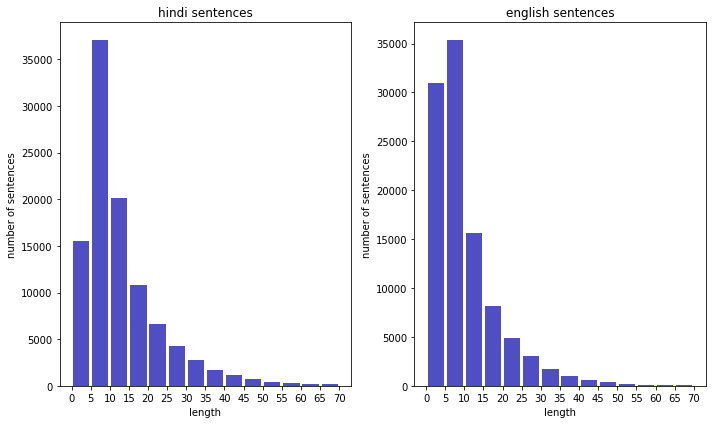

In [ ]:
#histogram of sentence length
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
axes[0].hist(hindi_len,bins=[5*i for i in range(15)],color='#0504aa',alpha=0.7, rwidth=0.85)
axes[0].set_xticks([5*i for i in range(15)])
axes[0].set_xlabel("length")
axes[0].set_title("hindi sentences")
axes[0].set_ylabel("number of sentences")
axes[1].hist(eng_len,bins=[5*i for i in range(15)],color='#0504aa',alpha=0.7, rwidth=0.85)
axes[1].set_xticks([5*i for i in range(15)])
axes[1].set_title("english sentences")
axes[1].set_xlabel("length")
axes[1].set_ylabel("number of sentences")

plt.tight_layout()
fig.savefig("length_train.png",dpi=720)

We can see that most sentences are of length less than 10. After length of 25 there are very few sentences so, we choose 25 as max length to avoid outliers in train set

## Preprocessing

In [ ]:
# function to clean data
def clean_data(dataset,max_length=20):
  # remove dataset that has non ascii character in english part and keep sentences that has length less than max_length
  new_dataset = []
  i = 0
  for data in dataset:
    l_1 = len(indic_tokenize.trivial_tokenize(data[0])) #length of hindi sentence
    l_2 = len(data[1].split(" ")) #length of english sentence
    check_chr = True  
    for nh in non_hindi_chr: #checking if non hinid characters in hindi sentence
      if nh in data[0]:
        check_chr = False
        break
    #english sentence should not have other than ascii characters
    if re.search(r'[^\x00-\x7F]+',data[1]) == None and max(l_1,l_2) <= max_length and check_chr:
      new_dataset.append(data)
    #printing some removed sentences
    elif i<5:
      if i == 0: print("Some removed datasets")
      i += 1
      print("{}. \"{}\" , \"{}\"".format(i,data[0],data[1]))
  print("removed {} of {} datasets".format(len(dataset)-len(new_dataset),len(dataset)))
  return new_dataset

In [ ]:
#to preprocess english sentence
def preprocess_eng(sentence):
  sentence = sentence.lower().strip() #lower case letters
  # removing shortforms
  sentence = re.sub(r"i'm","i am",sentence)
  sentence = re.sub(r"let's","let us",sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"n't"," not",sentence)

  sentence = re.sub(r"([?.!,])", r" \1 ", sentence) #creating space b/w punctuation
  sentence = re.sub(r'[" "]+', " ", sentence) # removing multiple places
  sentence = sentence.strip()
  return sentence

#only used in evaluating not for final output
def postprocess_eng(sentence,remove_unk=False):
  # sentence = capitalize_str(sentence) #capitalize first
  sentence = sentence.capitalize() #capitalize first
  sentence = re.sub(r" i ",r" I ",sentence) #changes small 'i' to capital 'I' in sentence
  sentence = re.sub(r" ([?.!,'\:])",r"\1",sentence) #remove space b/w last word and punctuation
  if remove_unk: sentence = re.sub(r" <unk> ",r" ",sentence) # to remove <unk> token
  return sentence


In [ ]:
#preprocess data using above functions and check bleu score of preprocessed output
def data_preprocessing(dataset,max_length=20):
  new_dataset = []
  for data in dataset:
    new_dataset.append([data[0],preprocess_eng(data[1]),data[1]])
  new_dataset = clean_data(new_dataset,max_length)
  # comparing change in bleu score and meteor score
  total_bleu_score = 0
  total_meteor_score = 0
  for i in tqdm(range(len(new_dataset))):
    total_bleu_score += sentence_bleu([new_dataset[i][2].split(" ")], postprocess_eng(new_dataset[i][1]).split(" "))
    total_meteor_score += single_meteor_score(new_dataset[i][2],postprocess_eng(new_dataset[i][1]))

  l = len(new_dataset)
  print("\nbleu score {}".format(round(total_bleu_score/l,2)))
  print("meteor score {}".format(round(total_meteor_score/l,2)))

  return new_dataset

After removing some noisy sentences (as shown in data analysis) and setting max length to 25, we get 89,076 sentences. Then we apply some preprocessing techniques on english sentences like lower casing, removing some shortforms and creating space between word and punctuation.
We compared our english dataset after applying preprocessing and postprocessing to actual dataset and shows how much applying these techniques hurt BLEU and METEOR scores.

**Note:** postprocessing is only used for testing not used in final output

In [ ]:
dataset = data_preprocessing(orignal_dataset,max_length=25)

Some removed datasets
1. "एल सालवाडोर मे, जिन दोनो पक्षों ने सिविल-युद्ध से वापसी ली, उन्होंने वही काम किये जो कैदियों की कश्मकश के निदान हैं।" , "in el salvador , both sides that withdrew from their civil war took moves that had been proven to mirror a prisoner's dilemma strategy ."
2. "पर मेरे लिए उसका यहुदी विरोधी होना उसके कार्यों को और भी प्रशंसनीय बनाता है क्योंकि उसके पास भी पक्षपात करने के वही कारण थे जो बाकी फौजियों के पास थे पर उसकी सच जानने और उसे बनाए रखने की प्रेरणा सबसे ऊपर थी" , "but personally , for me , the fact that picquart was anti-semitic actually makes his actions more admirable , because he had the same prejudices , the same reasons to be biased as his fellow officers , but his motivation to find the truth and uphold it trumped all of that ."
3. "तो स्मार्ट में, हमारे पास लक्ष्य के अलावा, मलेरिया टीका विकसित करने के, हम अफ्रीकी वैज्ञानिकों को भी प्रशिक्षण दे रहे हैं, क्योंकि अफ्रीका में बीमारी का बोझ काफी ज़्यादा है, और आपको उन लोगों की आवश्यकता है जो सीमाओं को आ



bleu score 0.58
meteor score 0.92


preprocessing hurts BLEU score by big margin but have less impact on METEOR score

In [ ]:
#creating train,val and test set of data with 0.8,0.1,0.1 split
from sklearn.model_selection import train_test_split
train_set,val_set = train_test_split(dataset,test_size=0.2,random_state=42)
val_set,test_set = train_test_split(val_set,test_size=0.5,random_state=42)
len(train_set),len(val_set),len(test_set)

(71260, 8908, 8908)

## Tokenization

spacy for english and indic_tokenize for hindi

In [ ]:
from collections import Counter
import torch
import random
import spacy
nlp = spacy.load("en")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#class for creating vocab
class vocab:
  def __init__(self,counter,max_size):
    self.word2index = dict()
    self.index2word = ['<pad>', '<unk>', '<eos>', '<sos>']
    self.unk_idx = 1
    self.max_size = max_size+4
    words = sorted(counter.items(), key=lambda t: t[0])
    words.sort(key=lambda t: t[1], reverse=True)
    for w,i in words:
      if len(self.index2word) == self.max_size:
        break
      self.index2word.append(w)
    for i in range(len(self.index2word)):
      self.word2index[self.index2word[i]] = i
  def __len__(self):
    return len(self.index2word)
  def __getitem__(self,word):
    return self.word2index.get(word,self.unk_idx)

In [ ]:
#spacy for english tokenization and indic library for hindi
eng_tokenizer = lambda sentence: [tok.text for tok in nlp.tokenizer(sentence)]
hindi_tokenizer = indic_tokenize.trivial_tokenize

In [ ]:
#if have stored vocabulary, then load using code below
#uncomment this then

# with open("gdrive/MyDrive/final_model/hindi_vocab.pickle", 'rb') as handle:
#     hindi_vocab =  pickle.load(handle)
# with open("gdrive/MyDrive/final_model/eng_vocab.pickle", 'rb') as handle:
#     eng_vocab =  pickle.load(handle)

#if using stored vocabulary ignore this section for inference task and goto model section

In [ ]:
##uncomment if using saved tokenized sentence
#spacy tokenization taking very long time (about 40-50 mins)
#so i tokenized all sentences once using spacy and saved as pickle
with open("gdrive/MyDrive/cs779_model/final_eng_sen.pickle", 'rb') as handle:
    eng_sen =  pickle.load(handle)


#tokenizing english sentences
#may take 40-50 mins
# eng_sen = dict()
# for data in tqdm(dataset):
#   eng_sen[data[1]] = eng_tokenizer(data[1])

In [ ]:
#function to get all words in given sentences
def get_vocab(dataset,eng_tokenizer,hindi_tokenizer):
  eng_counter = Counter()
  hindi_counter = Counter()
  for data in tqdm(dataset):
    # using already computed spacy tokenize sentences
    eng_counter.update(eng_sen[data[1]])
    hindi_counter.update(hindi_tokenizer(data[0]))
    
  return eng_counter,hindi_counter

In [ ]:
eng_counter,hindi_counter = get_vocab(train_set,eng_tokenizer,hindi_tokenizer)

### Analysis of Vocab

In [ ]:
#no of words in englsih and hindi
print("total words in english vocabulary = {}".format(len(eng_counter)))
print("total words in hindi vocabulary = {}".format(len(hindi_counter)))

total words in english vocabulary = 22933
total words in hindi vocabulary = 31245


In [ ]:
eng_words = list(eng_counter.items())
hindi_words = list(hindi_counter.items())

eng_freq = [f for _,f in eng_words]
hindi_freq = [f for _,f in hindi_words]

top_eng = eng_counter.most_common(10)
top_hindi = hindi_counter.most_common(10)
print("top hindi words: ",end="")
for w,f in top_hindi: print("(\"{}\",{})".format(w,f),end=" ")
print("\ntop english words: ",end="")
for w,f in top_eng: print("(\"{}\",{})".format(w,f),end=" ")

top hindi words: (".",38588) ("है",27802) (",",24071) ("।",20274) ("के",14000) ("में",10985) ("हैं",10715) ("?",10265) ("मैं",10046) ("और",10029) 
top english words: (".",62150) (",",28427) ("the",19021) ("you",16261) ("i",15736) ("to",13191) ("a",11240) ("?",10811) ("and",10420) ("it",9490) 

In [ ]:
#for printing hindi words in plot, have to upload Mangal.ttf file
#ignore else
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname='Mangal.ttf', size=18)

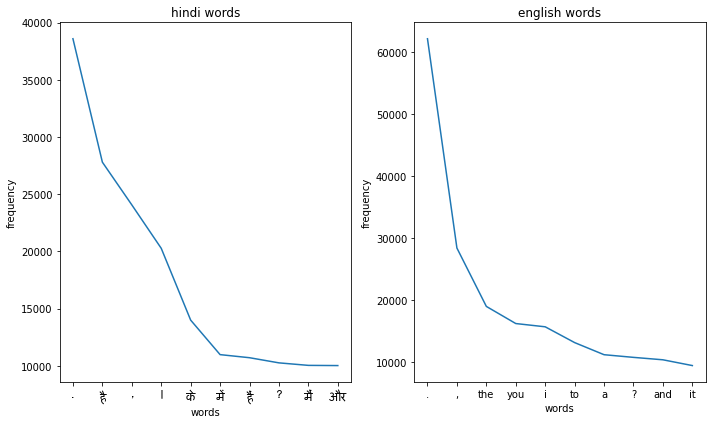

In [ ]:
#ignore this if dont have Mangal.ttf file
#plotting top 10 words with there frequency
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
axes[0].plot([w for w,_ in top_hindi],[f for  _,f in top_hindi])
axes[0].set_xticks([w for w,_ in top_hindi])
for label in axes[0].get_xticklabels():
    label.set_fontproperties(font_prop)
    label.set_fontsize(12)
axes[0].set_xlabel("words")
axes[0].set_ylabel("frequency")
axes[0].set_title("hindi words")
axes[1].plot([w for w,_ in top_eng],[f for  _,f in top_eng])
axes[1].set_title("english words")
axes[1].set_xlabel("words")
axes[1].set_ylabel("frequency")

plt.tight_layout()
fig.savefig("word_freq_plot.png",dpi=720)

graph shows that word distribution follows Zipf's law

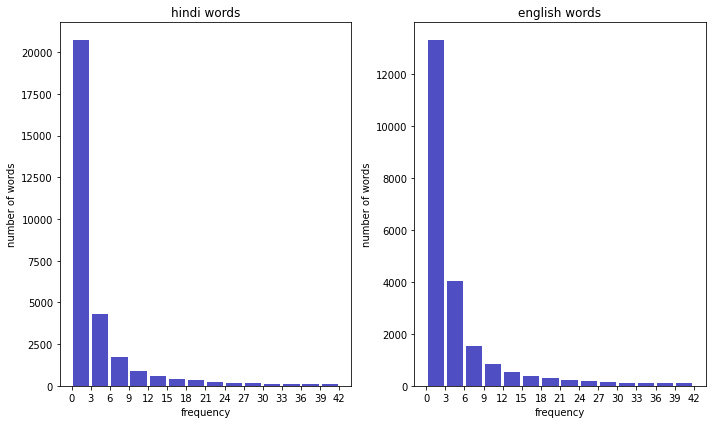

In [ ]:
#histogram of words frequency
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
axes[0].hist(hindi_freq,bins=[3*i for i in range(15)],color='#0504aa',alpha=0.7, rwidth=0.85)
axes[0].set_xticks([3*i for i in range(15)])
axes[0].set_xlabel("frequency")
axes[0].set_ylabel("number of words")
axes[0].set_title("hindi words")
axes[1].hist(eng_freq,bins=[3*i for i in range(15)],color='#0504aa',alpha=0.7, rwidth=0.85)
axes[1].set_xticks([3*i for i in range(15)])
axes[1].set_ylabel("number of words")
axes[1].set_title("english words")
axes[1].set_xlabel("frequency")

plt.tight_layout()
fig.savefig("word_freq.png",dpi=720)

Out of 31,245 words in hindi sentences around 20,000 words comes less than 3 times in all sentences. Out of 22,933 words in english sentences around 13,000 words comes less than 3 times in all sentences. So using these we take 10,000 as vocab size for both english and hindi sentences

In [ ]:
#Creating vocab using vocab size of 10k
#can ignore this if has stored vocabulary
eng_vocab = vocab(eng_counter,10000)
hindi_vocab = vocab(hindi_counter,10000)

In [ ]:
#function to tokenize data using vocab
def tokenize(dataset,eng_tokenizer,hindi_tokenizer,eng_vocab,hindi_vocab):
  tokenized_data = []
  for data in tqdm(dataset):
    # using precomputed spacy tokenize sentences
    eng_data = torch.tensor([eng_vocab['<sos>']]+[eng_vocab[t] for t in eng_sen[data[1]]]+[eng_vocab['<eos>']], dtype=torch.long)
    hindi_data = torch.tensor([hindi_vocab['<sos>']]+[hindi_vocab[t] for t in hindi_tokenizer(data[0])]+[hindi_vocab['<eos>']], dtype=torch.long)
    tokenized_data.append([hindi_data,eng_data])
  return tokenized_data

In [ ]:
tokenized_train_data= tokenize(train_set,eng_tokenizer,hindi_tokenizer,eng_vocab,hindi_vocab)
tokenized_val_data= tokenize(val_set,eng_tokenizer,hindi_tokenizer,eng_vocab,hindi_vocab)
tokenized_test_data = tokenize(test_set,eng_tokenizer,hindi_tokenizer,eng_vocab,hindi_vocab)

creating batches of data and padding them using pytorch dataloader

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 128
pad_hindi = hindi_vocab['<pad>']
pad_eng = eng_vocab['<pad>']

In [ ]:
def get_data(data):
  hindi_data = []
  eng_data = []
  for hindi_sen,eng_sen in data:
    hindi_data.append(hindi_sen)
    eng_data.append(eng_sen)
  hindi_data = pad_sequence(hindi_data,padding_value=pad_hindi)
  eng_data = pad_sequence(eng_data,padding_value=pad_eng)
  return hindi_data,eng_data

In [ ]:
train_data = DataLoader(tokenized_train_data, batch_size=BATCH_SIZE,shuffle=True,collate_fn=get_data)
val_data = DataLoader(tokenized_val_data, batch_size=BATCH_SIZE,shuffle=True,collate_fn=get_data)
test_data = DataLoader(tokenized_test_data, batch_size=BATCH_SIZE,shuffle=True,collate_fn=get_data)

##Model

Transformer model with padding mask on encoder and look ahead mask on decoder so input in decoder can only attend value in left of it

In [ ]:
from torch import nn
from torch.nn import LSTM,GRU,Linear,Embedding,Transformer
import torch.optim as optim
import time
import math

In [ ]:
class transformer(nn.Module):
  def __init__(self,device,e_vocab_size,d_vocab_size,hid_size=256,nhead=8,enc_layer=4,dec_layer=4,ff=1024):
    super().__init__()
    self.device = device
    self.hid_size = hid_size
    self.enc_embedding = Embedding(e_vocab_size,hid_size) 
    self.dec_embedding = Embedding(d_vocab_size,hid_size)
    #Transformer layer
    self.trans = Transformer(d_model=hid_size,nhead=nhead,num_encoder_layers=enc_layer,num_decoder_layers=dec_layer,dim_feedforward=ff)
    self.out = Linear(hid_size,d_vocab_size)

  def padding_mask(self,input):
    #creating padding mask (padded value will not be attended)
    mask = (input == 0)
    mask = mask.permute(1,0)
    return mask

  def forward(self,enc_input,dec_input):
    enc_mask = self.padding_mask(enc_input).to(device) #encoder padding mask
    dec_mask = self.padding_mask(dec_input).to(device) #decoder padding mask
    sen_length = dec_input.shape[0] #decoder sentence length
    look_ahead_mask = self.trans.generate_square_subsequent_mask(sen_length).to(device) #look ahead mask for decoder
    enc_embed = self.enc_embedding(enc_input)*math.sqrt(self.hid_size) #encoder embedding
    dec_embed = self.dec_embedding(dec_input)*math.sqrt(self.hid_size) #deocder embedding
    output = self.trans(enc_embed,dec_embed,tgt_mask=look_ahead_mask,src_key_padding_mask=enc_mask,memory_key_padding_mask=enc_mask) #transformer output
    output = self.out(output) #output linear layer
    return output
    

In [ ]:
def train(model,dataset,optimizer,loss_fn,schedule):
  model.train()
  total_loss = 0
  for input,target in tqdm(dataset):
    # initializing optimizer
    optimizer.zero_grad()
    enc_input = input.to(device)
    target = target.to(device)
    dec_input = target[:-1] #for target first n-1 words are input and last n-1 words are output
    # ouput from model
    output = model(enc_input,dec_input)
    # from dim [len,batch_size] to [len*batch_size]
    target = target[1:].view(-1) #ignoring 0th values as its of <sos> 
    #from from dim [len,batch_size,vocab_size] to [len*batch_size,vocab_size]
    output = output.view(-1,output.shape[-1])
    # calculating loss
    batch_loss = loss_fn(output,target)
    # back propogation 
    batch_loss.backward()
    #upgrading gradients
    optimizer.step()
    #schedule step update learning rate of optimizer
    schedule.step(optimizer)
    total_loss += batch_loss.item()
  
  return total_loss/len(dataset)

def evaluate(model,dataset,loss_fn):
  model.eval() #to avoid dropout and other things use during training
  total_loss = 0
  with torch.no_grad(): #not compute graidents
    for input,target in dataset:
      input = input.to(device)
      target = target.to(device)
      output = model(input,target[:-1])
      target = target[1:].view(-1)
      output = output.view(-1,output.shape[-1])
      # calculating loss on eval set
      batch_loss = loss_fn(output,target)
      total_loss += batch_loss.item()
  
  return total_loss/len(dataset)

In [ ]:
#if validation loss increase by more than stop it terminates training
def fit(model,train_data,val_data,optimizer,loss_fn,schedule,name="model",EPOCHS=10,stop=0.1,test_data=None):
    history = [] #used for futher analysis and graph
    min_val = 10000 #used in finding parameters with least val set loss
    for epoch in range(EPOCHS):
        start = time.time()
        train_loss = train(model,train_data, optimizer,loss_fn,schedule)
        val_loss = evaluate(model,val_data,loss_fn)  
        end = time.time()
        print("train loss: {:.3f} val loss: {:.3f}".format(train_loss,val_loss))
        t = end - start
        print("time taken by {} epoch {} min {} s".format(epoch+1,int(t/60),int(t%60)))
        history.append({
            "epoch":epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "time": t,
        })
        if val_loss<min_val:
            min_val = val_loss
             #saving best model
            torch.save(model.state_dict(), name+'_best.pt')
        # stop training if val_loss increase more than by stop
        if val_loss > min_val*(1+stop):
            break
    #saving model on last epoch
    torch.save(model.state_dict(), name+'.pt')
    #evaluating both best and last model on test set
    if test_data is not None:
        test_loss = evaluate(model,test_data,loss_fn)
        model.load_state_dict(torch.load(name+'_best.pt'))
        test_loss_best = evaluate(model,test_data,loss_fn)
        print("test loss: {:.3f} test loss on best val: {:.3f}".format(test_loss,test_loss_best))
    
    return history

In [ ]:
#using vocabulary size of 10004 for both english and hindi
e_vocab_size = len(hindi_vocab) #encoder vocab size
d_vocab_size = len(eng_vocab) #decoder vocab size
#using hidden dimension as 512
hid_size=512
#using 4 layers for both encoder and decoder with 8 attention heads
enc_layer=4
dec_layer=4
nhead=8
#using size = 1024 for feedforward layer
ff=1024

In [ ]:
model = transformer(device,e_vocab_size,d_vocab_size,hid_size=hid_size,nhead=nhead,enc_layer=enc_layer,dec_layer=dec_layer,ff=ff).to(device)

In [ ]:
#counting no. of parameters in model
def parameters_count(model):
    return sum(parameter.numel() for parameter in model.parameters() if parameter.requires_grad)

In [ ]:
print(parameters_count(model)) #36.4M

36407060


In [ ]:
#to load if model already trained else ignore
#change file name accordingly

model.load_state_dict(torch.load("gdrive/MyDrive/final_model/transformer_best.pt"))

#if using trained model for inference ignore training and evaluating section, goto translating section

<All keys matched successfully>

##Training

In [ ]:
#scheduler to update learning rate of optimizer according to steps
#learning rate increase till warmupsteps and then decrease as steps increase
class scheduler:
  def __init__(self,dim_size,warmup_steps=4000):
    self.steps = 0
    self.dim_size = dim_size
    self.warmup_steps = warmup_steps
  def step(self,optimizer):
    self.steps += 1
    arg1 = 1/math.sqrt(self.steps)
    arg2 = self.steps/(self.warmup_steps**1.5)
    lr = min(arg1,arg2)/math.sqrt(self.dim_size)
    for p in optimizer.param_groups:
      p['lr'] = lr

In [ ]:
#using cross entropy loss with ignoring output for padded values
loss_fn = nn.CrossEntropyLoss(ignore_index = pad_eng)
#using adam optimizer (as dicussed in class)
optimizer = torch.optim.Adam(model.parameters(),1e-4,betas=(0.9, 0.98))
#scheduler
schedule = scheduler(dim_size=hid_size) 

In [ ]:
#using 15 epochs
#takes around 30 mins
history = fit(model,train_data,val_data,optimizer,loss_fn,name="transformer",test_data=test_data,EPOCHS=15,schedule=schedule)


train loss: 5.765 val loss: 4.343
time taken by 1 epoch 4 min 0 s



train loss: 4.127 val loss: 3.705
time taken by 2 epoch 3 min 59 s



train loss: 3.646 val loss: 3.377
time taken by 3 epoch 4 min 0 s


KeyboardInterrupt: ignored

##Evaluating

compare results on test set with beam width = 1 and 3

In [ ]:
#using beam search in inference
def inference(model,sentence,eng_vocab,bs=3,max_len=40):
  #using auto regressive method for inference
  model.eval() #in eval model
  #dim from [len] to [len,1] (as not in batches)
  sentence = sentence.unsqueeze(1).to(device)
  outputs = [([eng_vocab['<sos>']],0)]
  with torch.no_grad():
    for i in range(max_len):
      end_reach = True
      new_outputs = []
      for output,p in outputs:
        if output[-1] != eng_vocab['<eos>']:
          end_reach = False
          #input to decoder
          dec_input = torch.tensor(output,dtype=torch.long).unsqueeze(1).to(device)
          out = model(sentence,dec_input) #decoder output
          out = out[-1] #last word predicted
          out = torch.softmax(out,dim=1) #softmax to calculate probability
          out_k = out.view(-1).topk(bs)
          #adding top k prediction
          for k in range(bs):
            pred = out_k.indices[k].item()
            pred_p = math.log(out_k.values[k].item())
            new_output = (output+[pred],p+pred_p)
            new_outputs.append(new_output)
        else:
          new_outputs.append((output,p))
      # print(len(new_outputs))
      if end_reach: break
      #sorting on sum(log(prob))/length for length normalization else model will promote smaller sentences
      new_outputs.sort(key = lambda x: x[1]/(len(x[0])) , reverse=True)
      #taking top bs sentences
      outputs = new_outputs[:bs]
  #best sentence
  out,p = outputs[0]
  return out[1:-1],p

In [ ]:
#evaluate model on METEOR and BLEU scores on test set
def score_data(test,model,inference,eng_vocab,hindi_vocab,hindi_tokenizer,bs=3,remove_unk=False):
    total_bleu_score_p = 0
    total_meteor_score_p = 0
    total_bleu_score = 0
    total_meteor_score = 0
    for i in tqdm(range(len(test))):
        data = test[i]
        tokenized = torch.tensor([hindi_vocab['<sos>']]+[hindi_vocab[t] for t in hindi_tokenizer(data[0])]+[hindi_vocab['<eos>']], dtype=torch.long)
        output,p = inference(model,tokenized,eng_vocab,bs=bs)
        output = " ".join([eng_vocab.index2word[t] for t in output])
        #without postprocessing on output after preprocessing
        total_bleu_score += sentence_bleu([data[1].split(" ")], output.split(" "))
        total_meteor_score += single_meteor_score(data[1],output)
        #with postprocessing on output from actual data
        total_bleu_score_p += sentence_bleu([data[2].split(" ")], postprocess_eng(output,remove_unk).split(" "))
        total_meteor_score_p += single_meteor_score(data[2],postprocess_eng(output,remove_unk))

    l = len(test)
    print("\nbleu score {:.4f}, bleu score with on actual {:.4f}".format(total_bleu_score/l,total_bleu_score_p/l))
    print("meteor score {:.4f}, meteor score with on actual {:.4f}".format(total_meteor_score/l,total_meteor_score_p/l))

In [ ]:
#selectin beam width by evaluating meteor and bleu score on test_set
#can skip this parts (as take around 40 mins)

In [ ]:
#can ignore takes 10 mins
#using beam_width = 1 (same as greedy search)
score_data(test_set,model,inference,eng_vocab,hindi_vocab,hindi_tokenizer,bs=1)



bleu score 0.1021, bleu score with on actual 0.0352
meteor score 0.4528, meteor score with on actual 0.3052


In [ ]:
#can ignore takes 30 mins
#using beam_width = 3
score_data(test_set,model,inference,eng_vocab,hindi_vocab,hindi_tokenizer,bs=3)



bleu score 0.1123, bleu score with on actual 0.0396
meteor score 0.4630, meteor score with on actual 0.3158


using beam width of 3 increases meteor and bleu score but it also takes lots of time

##Translating

In [ ]:
bs = 3 #beam size = 3
def translate(sentence):
  token_sen = torch.tensor([hindi_vocab['<sos>']]+[hindi_vocab[t] for t in hindi_tokenizer(sentence)]+[hindi_vocab['<eos>']], dtype=torch.long)
  output,p = inference(model,token_sen,eng_vocab,bs=bs)
  output = " ".join([eng_vocab.index2word[t] for t in output])
  print("[HINDI] => {}\n[ENGLISH] => {}".format(sentence,output))

In [ ]:
translate("मैं कॉलेज जा रहा हूं।")

[HINDI] => मैं कॉलेज जा रहा हूं।
[ENGLISH] => i am going to college .


creating output of dev set

In [ ]:
#sentences in final test file
#upload "testhindistatements.csv" file
test_file = "testhindistatements.csv"
sample = []
with open(test_file,encoding="utf-8") as f:
  csv_reader = csv.reader(f, delimiter=',')
  i = 0
  for r in csv_reader:
    if i == 0:
      i = 1
      continue
    sample.append(r[2])

In [ ]:
len(sample)

24102

In [ ]:
def final_result(model,inference,sample,hindi_tokenizer,hindi_vocab,eng_vocab,bs=3):
  result = []
  for s in tqdm(sample):
    hindi_s = torch.tensor([hindi_vocab['<sos>']]+[hindi_vocab[t] for t in hindi_tokenizer(s)]+[hindi_vocab['<eos>']], dtype=torch.long)
    output,p = inference(model,hindi_s,eng_vocab,bs=bs)
    output = " ".join([eng_vocab.index2word[t] for t in output]) 
    result.append(output)
  return result

In [ ]:
#final outcome (takes around 1hr 40mins for 24102 sentences)
result = final_result(model,inference,sample,hindi_tokenizer,hindi_vocab,eng_vocab,bs=bs)

In [ ]:
#checking output of random sentence in sample
r = int(random.randint(0,len(sample)))
sample[r], result[r]

('वे किया था?', 'they did ?')

In [ ]:
#creating answer.txt
f = open("answer.txt", "w")
for s in result:
  f.write(s+"\n")
f.close()

## Data Analysis on dev set and final output 

In [ ]:
#sentences with <unk> token in dev set
unk_token = hindi_vocab['<unk>']
unk_list = []
total = 0
for s in sample:
  count = 0
  for t in hindi_tokenizer(s):
    if hindi_vocab[t] == unk_token:
      count += 1
  unk_list.append(count)
  if count != 0: total += 1
avg_unk = sum(unk_list)/len(unk_list)

In [ ]:
print("total {} sentences has unknown word out of {} hindi sentences in dev set".format(total,len(sample)))
print("Average number of unknown word per sentence is {}".format(avg_unk))

total 8463 sentences has unknown word out of 24102 hindi sentences in dev set
Average number of unknown word per sentence is 0.646253422952452


Although about 35% sentences has unknown words but still average is less than 1. Histogram will give more clear picture

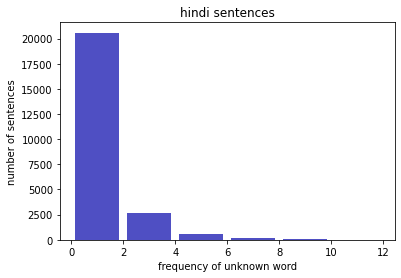

In [ ]:
#histogram of words frequency
# fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
plt.hist(unk_list,bins=[2*i for i in range(7)],color='#0504aa',alpha=0.7, rwidth=0.85)
plt.xticks([2*i for i in range(7)])
plt.xlabel("frequency of unknown word")
plt.ylabel("number of sentences")
plt.title("hindi sentences")

plt.savefig("freq_unk.png",dpi=720)

we can see that more than 20000 hindi sentences in dev set has less than 2 unk words, so most of sentences has either 0 or just 1 unknown words.

In [ ]:
#unk word in eglish output in relation with input
unk_list_e = []
total = 0

for s in result:
  count = 0
  for t in s.split(" "):
    if t == "<unk>":
      count += 1
  unk_list_e.append(count)
  total += min(count,1)
avg_unk = sum(unk_list_e)/len(unk_list_e)

In [ ]:
print("total {} sentences has unknown word out of {} english sentences in result".format(total,len(result)))
print("Average number of unknown word per sentence is {} in outout".format(avg_unk))

total 5597 sentences has unknown word out of 24102 english sentences in result
Average number of unknown word per sentence is 0.4374325782092772 in outout


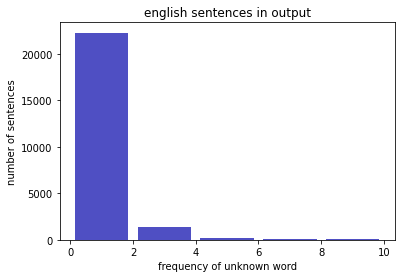

In [ ]:
plt.hist(unk_list_e,bins=[2*i for i in range(6)],color='#0504aa',alpha=0.7, rwidth=0.85)
plt.xticks([2*i for i in range(6)])
plt.xlabel("frequency of unknown word")
plt.ylabel("number of sentences")
plt.title("english sentences in output")

plt.savefig("freq_unk_result.png",dpi=720)


In result very few english sentences has unknown word 

In [ ]:
#sentences that have unk word in hindi but not in english and vice versa
count1 = 0
count2 = 0
for h,e in zip(unk_list,unk_list_e):
  if e == 0 and h != 0:
    count1 += 1
  if h == 0 and e != 0:
    count2 += 1

print("number of data in dev set that has unknown word in hindi input sentence but not in output english sentence = ",count1)
print("number of data in dev set that has unknown word in english ouput sentence but not in input hindi sentence = ",count2)

number of data in dev set that has unknown word in hindi input sentence but not in output english sentence =  3526
number of data in dev set that has unknown word in english ouput sentence but not in input hindi sentence =  660


So out of about 15,600 hindi input sentences without unknown word only very few 660 sentences resulted in unknown word in english output. So our model rarely create unknown word in output if it is not in input

In [ ]:
eng_len = []
hindi_len = []
for i in range(len(sample)):
  hindi_len.append(len(indic_tokenize.trivial_tokenize(sample[i])))
  eng_len.append(len(result[i].split(" ")))

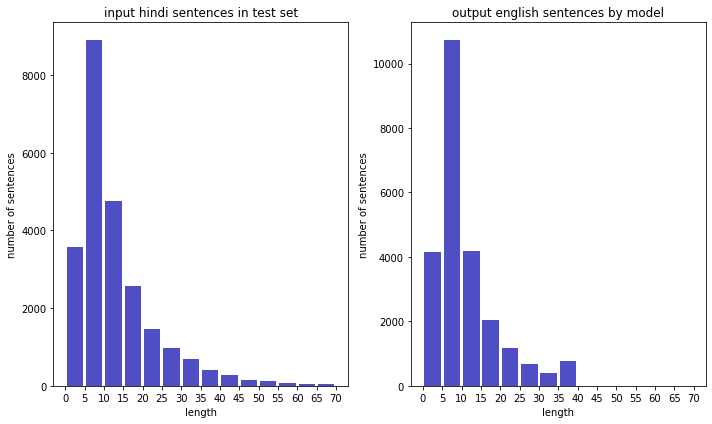

In [ ]:
#histogram of sentence length in test set
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
axes[0].hist(hindi_len,bins=[5*i for i in range(15)],color='#0504aa',alpha=0.7, rwidth=0.85)
axes[0].set_xticks([5*i for i in range(15)])
axes[0].set_xlabel("length")
axes[0].set_title("input hindi sentences in test set")
axes[0].set_ylabel("number of sentences")
axes[1].hist(eng_len,bins=[5*i for i in range(15)],color='#0504aa',alpha=0.7, rwidth=0.85)
axes[1].set_xticks([5*i for i in range(15)])
axes[1].set_title("output english sentences by model")
axes[1].set_xlabel("length")
axes[1].set_ylabel("number of sentences")

plt.tight_layout()
fig.savefig("length_test.png",dpi=720)

As we have used 40 as max length in inference so output has sentence of only maximum 40 length. But we can see that about less than 1000 sentences came in that range.

In [ ]:
#saving vocab as pickle
with open('hindi_vocab.pickle', 'wb') as f:
    pickle.dump(hindi_vocab, f)
with open('eng_vocab.pickle', 'wb') as f:
    pickle.dump(eng_vocab, f)


In [ ]:
#can ignore
#saving vocabulary and best model in drive
# !cp eng_vocab.pickle gdrive/MyDrive/final_model/
# !cp hindi_vocab.pickle gdrive/MyDrive/final_model/
# !cp transformer_best.pt gdrive/MyDrive/final_model/